### Loading PACE Chlorophyll Data

Went to Nasa's Earth Data website https://search.earthdata.nasa.gov/ to download data. 

- searched 'PACE'
-  put it temporal range
-  hit downlaod all... Harmony did not work for me
-  downloaded Earthdata Download in order to create a .zip file

In [1]:
import os, re
import earthaccess
import numpy as np

In [2]:
# choose times
temporal = ("2024-06-04", "2024-11-11")

# login to nasa
auth = earthaccess.login()

List of PACE products:

https://search.earthdata.nasa.gov/search?q=pace

In [3]:
results_day = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL",
    temporal = temporal,
    granule_name="*.DAY.*.4km.*"
)
len(results_day)

158

In [4]:
# load the data
fileset = earthaccess.open(results_day)


QUEUEING TASKS | :   0%|          | 0/158 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/158 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/158 [00:00<?, ?it/s]

In [5]:
# We need to create the dates from the fileset since the original files do not have the time
import pandas as pd
import re

# Extract dates from file paths
date_pattern = re.compile(r"PACE_OCI\.(\d{8})")

dates = []
for f in fileset:
    match = date_pattern.search(f.path)
    if not match:
        raise ValueError(f"Could not extract date from: {f.path}")
    date_str = match.group(1)
    dates.append(pd.to_datetime(date_str, format="%Y%m%d"))

# Sanity check
if len(dates) != len(fileset):
    raise ValueError(f"Mismatch: found {len(dates)} dates for {len(fileset)} files")

dates[0:3]

[Timestamp('2024-06-04 00:00:00'),
 Timestamp('2024-06-05 00:00:00'),
 Timestamp('2024-06-06 00:00:00')]

from dataset create xarray

In [6]:
import xarray as xr
CHL = xr.open_mfdataset(
    fileset,
    combine="nested",
    concat_dim="time"
)

# Overwrite with correct dates
CHL = CHL.assign_coords(time=("time", dates))

In [7]:
CHL

<xarray.Dataset> Size: 24GB
Dimensions:  (time: 158, lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 1kB 2024-06-04 2024-06-05 ... 2024-11-11
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (time, lat, lon) float32 24GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (time, rgb, eightbitcolor) uint8 121kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240604.L3m.DAY.CHL.V3_0.chl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/3.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         2617778
    data_minimum:                      0.00943225
    data_maximum:                      99.97876

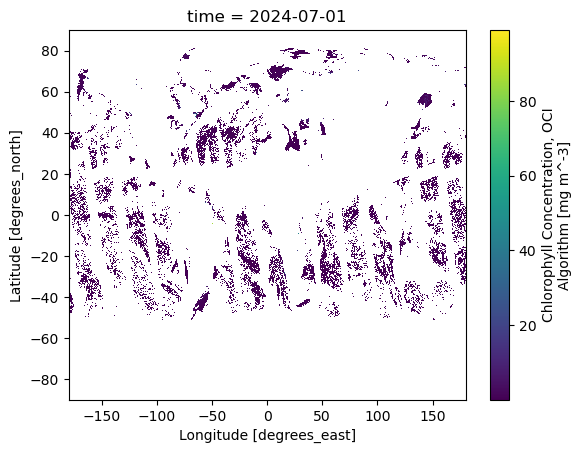

In [8]:
CHL['chlor_a'].sel(time='2024-07-01', method='nearest').plot();

### playing w plotting

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# user inputs

lat_rng = slice(42, 25)     
lon_rng = slice(-82, -72)   

time = np.datetime64("2024-10-14")

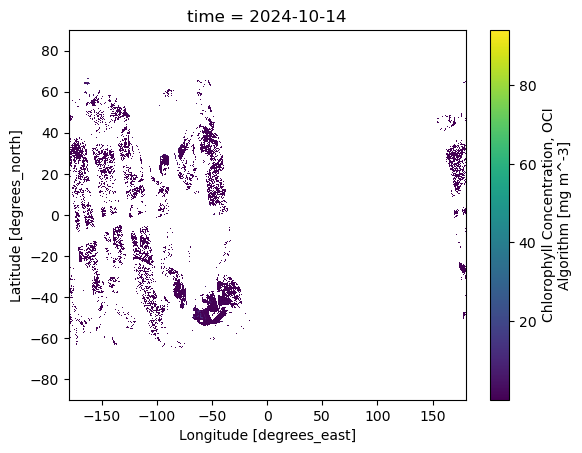

In [10]:
CHL["chlor_a"].sel(time=time, method='nearest').plot();

In [11]:
lat_east = slice(42, 25)     
lon_east = slice(-82, -72)  

time = np.datetime64("2024-10-14")


CHL_east = CHL.sel(lat=lat_east, lon=lon_east)

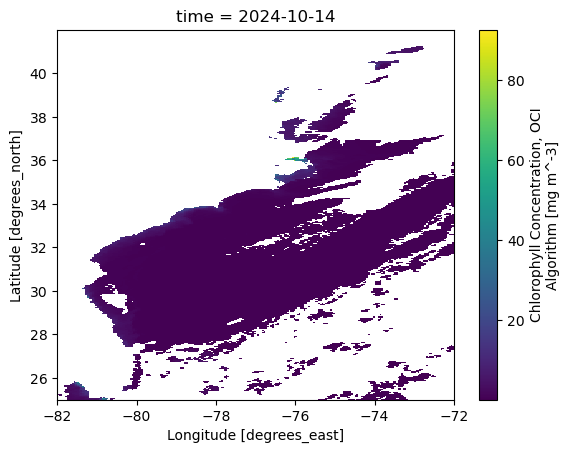

In [12]:
# first plot
CHL_east.chlor_a.sel(time=time, method='nearest').plot()

the scaling of chlorophyll seems to be off since everything's purple. trying out a log scale next

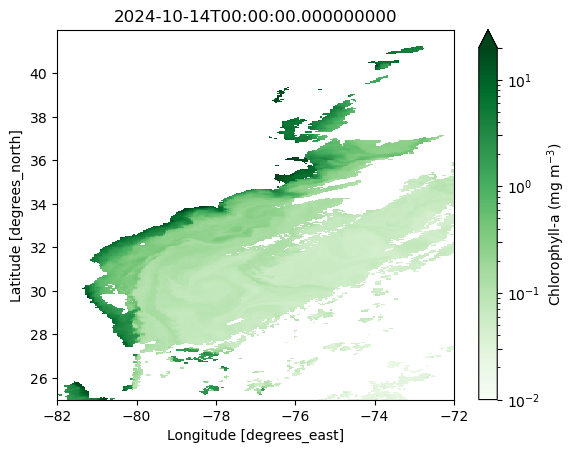

In [13]:
from matplotlib.colors import LogNorm

time = np.datetime64("2024-10-14")


CHL_east = CHL_east.chlor_a.sel(time=time, method='nearest').where(lambda x: x > 0)  # drop zeros for LogNorm
CHL_east = CHL_east.clip(min=0.01)

vmin, vmax = 0.01, 20  
CHL_east.plot(
    cmap="Greens",
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cbar_kwargs={
        "label": "Chlorophyll-a (mg m$^{-3}$)",
        "ticks": [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 20],
    },
)
plt.title(str(np.datetime_as_string(CHL_east.time.values)) if "time" in CHL_east.coords else "")
plt.show()


much better! now going to add coastlines using cartopy 

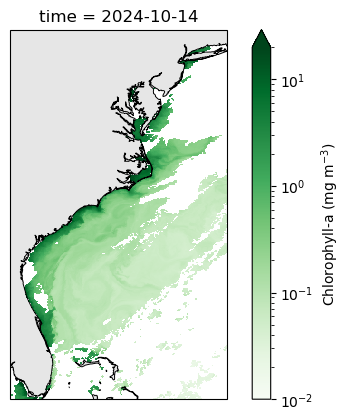

<Figure size 640x480 with 0 Axes>

In [14]:
# add coastlines
import cartopy.crs as ccrs, cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.PlateCarree())
CHL_east.plot(ax=ax, transform=ccrs.PlateCarree(),
        cmap="Greens", norm=LogNorm(0.01, 20),
        cbar_kwargs={"label": "Chlorophyll-a (mg m$^{-3}$)"})
ax.set_extent([-82, -72, 25, 42], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="0.9")   # land fill (1 line)
ax.coastlines("10m", linewidth=0.7)              # coastline/border (1 line)
plt.show()
plt.tight_layout()

starting to look cleaner... just going to adjust the plot data so we change fig size. The colorbar is currently too large and taking up a lot of the pot space

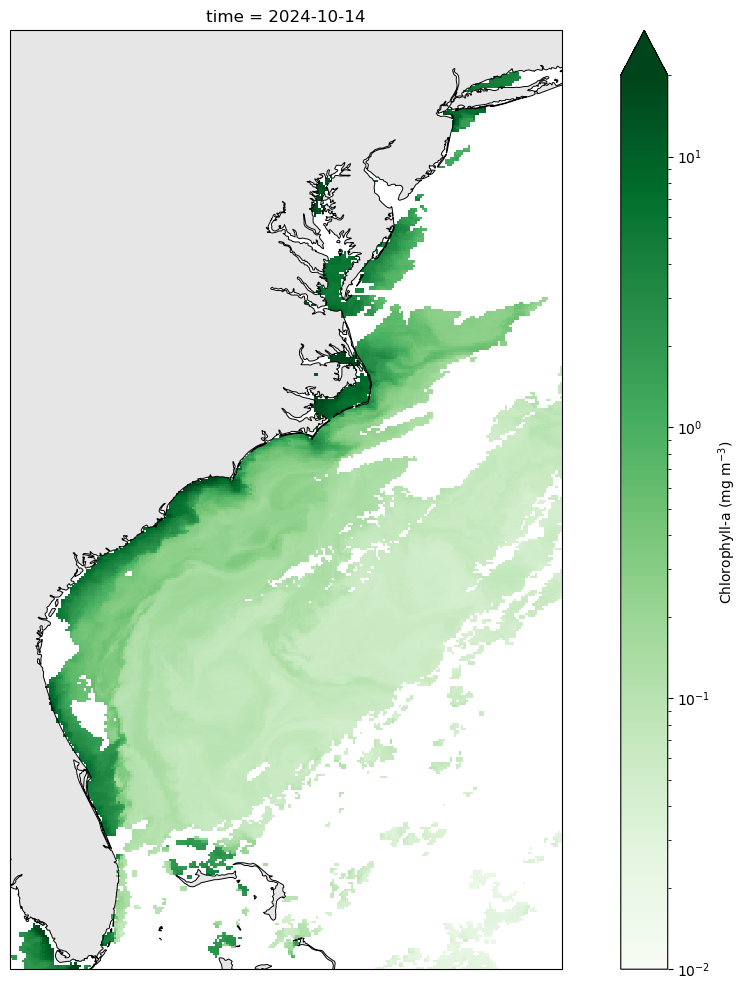

In [15]:
fig, ax = plt.subplots(
    figsize=(12, 10),                              
    subplot_kw={"projection": ccrs.PlateCarree()}
)

CHL_east.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="Greens", norm=LogNorm(0.01, 20),
    cbar_kwargs={"label": "Chlorophyll-a (mg m$^{-3}$)"}
)

ax.set_extent([-82, -72, 25, 42], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.coastlines("10m", linewidth=0.7)

plt.tight_layout()
plt.show()

#### West Coast

In [16]:
CHL_west

NameError: name 'CHL_west' is not defined

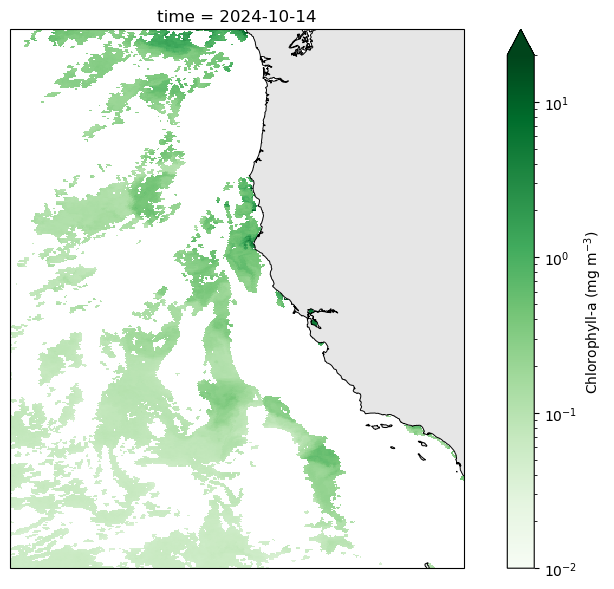

In [17]:
from matplotlib.colors import LogNorm

lat_west = slice(48, 29)     
lon_west = slice(-133, -117)  
time = np.datetime64("2024-10-14")


CHL_west = CHL.sel(lat=lat_west, lon=lon_west)
CHL_west = CHL_west.chlor_a.sel(time=time, method='nearest').where(lambda x: x > 0)  # drop zeros for LogNorm
CHL_west = CHL_west.clip(min=0.01)

fig, ax = plt.subplots(
    figsize=(9, 6),                              
    subplot_kw={"projection": ccrs.PlateCarree()}
)

CHL_west.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="Greens", norm=LogNorm(0.01, 20),
    cbar_kwargs={"label": "Chlorophyll-a (mg m$^{-3}$)"}
)

ax.set_extent([-133, -117, 29, 48], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.coastlines("10m", linewidth=0.7)

plt.tight_layout()
plt.show()

**Resources:**

https://github.com/oceanhackweek/ohw24_proj_pace_us/blob/main/final_notebooks/Hypercoast(PACE)_with_IFCB.ipynb

https://github.com/nmfs-opensci/NMFSHackDays-2025/blob/main/topics-2025/2025-PACE/pace-chl.ipynb

In [ ]:
CHL.coords